## Load data

In [198]:
# community_analysis.ipynb

# 📌 SECTION 1: IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

In [199]:
# 📌 SECTION 2: LOAD DATA
base_path = "../data/full"
algo = "reverse_hybrid"
# algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [200]:
# 📌 SECTION 3: MERGE COMMUNITY ASSIGNMENTS
merged_df = pd.merge(patient_df, community_df, on='patientId', how='inner')

# Optional: Label community types if needed
# community_df['communityType'] = community_df['nodeId'].apply(...)  # if SLPA vs Leiden tags exist

merged_df.shape

(1062, 30)

In [201]:
# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

## Clinical Analysis

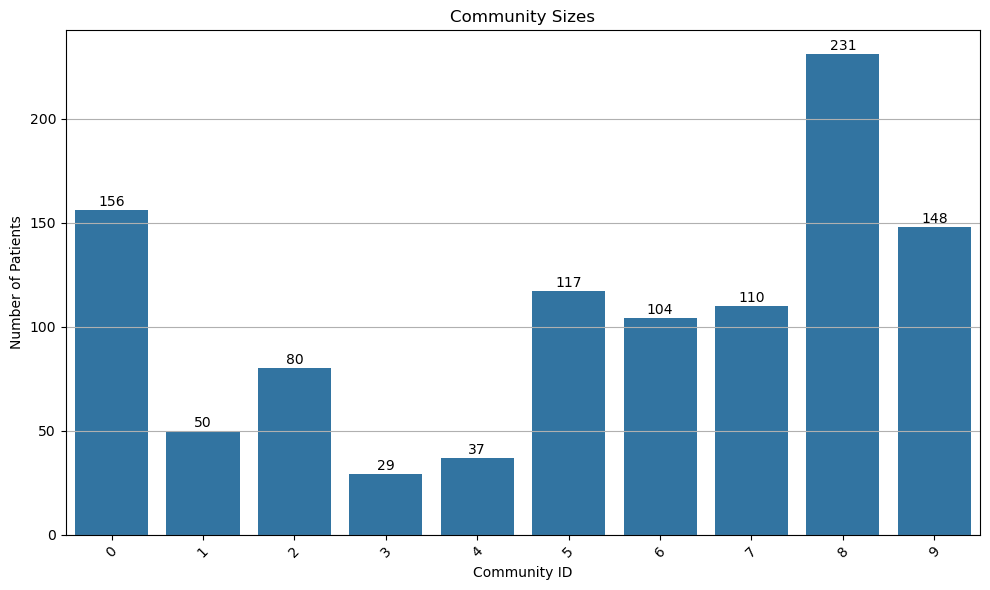

In [202]:
# plot community sizes
def plot_community_sizes(community_df):
    community_counts = community_df['communityId'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=community_counts.index, y=community_counts.values)
    plt.title("Community Sizes")
    plt.xlabel("Community ID")
    plt.ylabel("Number of Patients")
    plt.xticks(rotation=45)
    # annotate count on bars
    for i, count in enumerate(community_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_community_sizes(community_df)

In [203]:
from collections import defaultdict

def print_overlapping_nodes(community_df):
    """
    Prints patientIds that belong to multiple communities and their memberships.
    """
    patient_to_comms = defaultdict(set)
    for _, row in community_df.iterrows():
        patient_to_comms[row['patientId']].add(row['communityId'])
    overlapping = {pid: list(comms) for pid, comms in patient_to_comms.items() if len(comms) > 1}
    print(f"Number of overlapping patients: {len(overlapping)}")
    if overlapping:
        print("Overlapping patients and their community memberships:")
        for pid, comms in overlapping.items():
            print(f"  PatientId: {pid} -> Communities: {sorted(comms)}")
    else:
        print("No overlapping patients found.")

# Call the function
print_overlapping_nodes(community_df)

Number of overlapping patients: 54
Overlapping patients and their community memberships:
  PatientId: P-CRC-0008 -> Communities: [3, 6]
  PatientId: P-DFCI-5049 -> Communities: [3, 6]
  PatientId: P-CRC-0014 -> Communities: [3, 6]
  PatientId: P-DFCI-5115 -> Communities: [3, 6]
  PatientId: P-CRC-0004 -> Communities: [3, 5]
  PatientId: P-DFCI-5066 -> Communities: [3, 6]
  PatientId: P-SCLL-0054 -> Communities: [3, 6]
  PatientId: P-SCLL-0031 -> Communities: [3, 6]
  PatientId: P-CRC-0013 -> Communities: [3, 6]
  PatientId: P-DFCI-5143 -> Communities: [3, 6]
  PatientId: P-SCLL-0020 -> Communities: [3, 5]
  PatientId: P-NHLBI-0075 -> Communities: [3, 6]
  PatientId: P-DFCI-5184 -> Communities: [4, 6]
  PatientId: P-DFCI-5068 -> Communities: [4, 6]
  PatientId: P-SCLL-0258 -> Communities: [4, 6]
  PatientId: P-DFCI-5095 -> Communities: [4, 6]
  PatientId: P-DFCI-5105 -> Communities: [4, 6]
  PatientId: P-DFCI-5129 -> Communities: [4, 6]
  PatientId: P-SCLL-0178 -> Communities: [4, 6]
  

In [204]:
# 📌 SECTION 4: COMMUNITY DEMOGRAPHIC ANALYSIS
def demographic_summary(df, groupby='communityId'):
    print("🔍 Age, Sex distribution per community:\n")
    print(df.groupby(groupby)['AGE_SAMPLING'].describe())
    print("\n🔹 Sex distribution:\n")
    print(pd.crosstab(df[groupby], df['SEX'], normalize='index'))

    sns.violinplot(data=df, x=groupby, y='AGE_SAMPLING')
    plt.title("Age Distribution per Community")
    plt.show()

    sns.countplot(data=df, x=groupby, hue='SEX')
    plt.title("Sex Distribution per Community")
    plt.show()

🔍 Age, Sex distribution per community:

             count       mean        std   min    25%   50%    75%   max
communityId                                                             
0            156.0  67.826923  11.966169  35.0  60.75  67.0  77.00  94.0
1             50.0  62.840000  11.660784  40.0  53.00  64.0  72.00  84.0
2             80.0  65.250000  10.732065  44.0  58.00  65.0  73.00  89.0
3             29.0  58.068966   9.746542  37.0  51.00  57.0  65.00  82.0
4             37.0  62.000000   9.524821  39.0  56.00  62.0  67.00  84.0
5            117.0  60.666667  10.850870  19.0  55.00  62.0  68.00  82.0
6            104.0  60.692308  11.136468  34.0  53.75  62.0  67.25  84.0
7            110.0  62.054545  10.336394  38.0  54.25  63.0  69.00  86.0
8            231.0  63.696970  10.973642  36.0  57.00  64.0  71.50  89.0
9            148.0  61.391892  12.030367  31.0  52.75  62.0  69.25  92.0

🔹 Sex distribution:

SEX            Female      Male
communityId                   

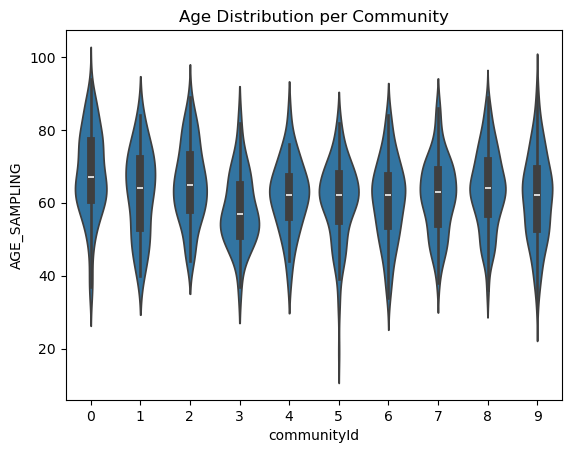

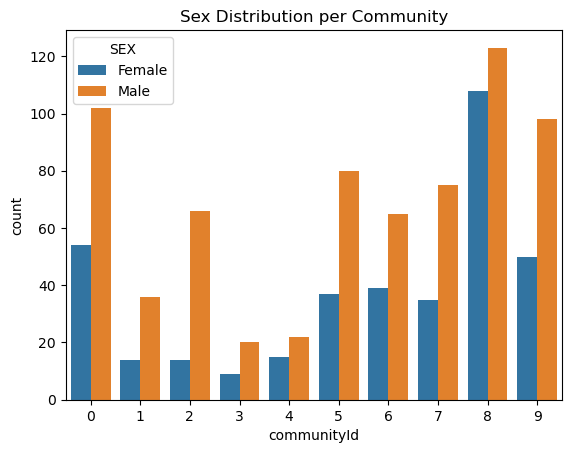

In [205]:
demographic_summary(merged_df)

In [206]:
import plotly.express as px
import plotly.graph_objects as go


def compare_age_mutation_count(merged_df, comm1, comm2):

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([comm1, comm2])], y='AGE_SAMPLING', x='communityId', box=True, points='all',
                        title='Violin Plot of AGE_SAMPLING by Community')
    fig_violin.show()

    # 1. Violin plot of AGE_SAMPLING grouped by community
    fig_violin = px.violin(merged_df[merged_df['communityId'].isin([comm1, comm2])], y='MUTATION_COUNT', x='communityId', box=True, points='all',
                        title='Violin Plot of MUTATION_COUNT by Community')
    fig_violin.show()

    # 2. KDE plot for AGE_SAMPLING for communities 1 and 2
    from scipy.stats import gaussian_kde

    # Filter data for communities 1 and 2
    df_1 = merged_df[merged_df['communityId'] == comm1]['AGE_SAMPLING']
    df_2 = merged_df[merged_df['communityId'] == comm2]['AGE_SAMPLING']

    # Generate KDEs
    kde_1 = gaussian_kde(df_1)
    kde_2 = gaussian_kde(df_2)

    x_vals = np.linspace(merged_df['AGE_SAMPLING'].min(), merged_df['AGE_SAMPLING'].max(), 200)
    y_1 = kde_1(x_vals)
    y_2 = kde_2(x_vals)

    # Create KDE plot
    fig_kde = go.Figure()
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_1, mode='lines', name=f'Community {comm1}'))
    fig_kde.add_trace(go.Scatter(x=x_vals, y=y_2, mode='lines', name=f'Community {comm2}'))
    fig_kde.update_layout(title=f'KDE Plot of AGE_SAMPLING for Communities {comm1} and {comm2}',
                        xaxis_title='AGE_SAMPLING',
                        yaxis_title='Density')
    fig_kde.show()

In [207]:
compare_age_mutation_count(merged_df, 3, 4)

In [208]:
compare_age_mutation_count(merged_df, 0, 2)

In [252]:
compare_age_mutation_count(merged_df, 5, 7)

In [209]:
# 📌 SECTION 5: CLINICAL ATTRIBUTE ANALYSIS
def clinical_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(pd.crosstab(df[groupby], df[feat], normalize='index'))

        sns.countplot(data=df, x=groupby, hue=feat)
        plt.title(f"{feat} per Community")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


🔬 IGHV_MUTATION_STATUS distribution per community:

IGHV_MUTATION_STATUS   mutated  unmutated
communityId                              
0                     0.316129   0.683871
1                     0.244898   0.755102
2                     0.423077   0.576923
3                     0.586207   0.413793
4                     0.432432   0.567568
5                     0.403509   0.596491
6                     0.500000   0.500000
7                     0.336449   0.663551
8                     0.850877   0.149123
9                     0.623288   0.376712


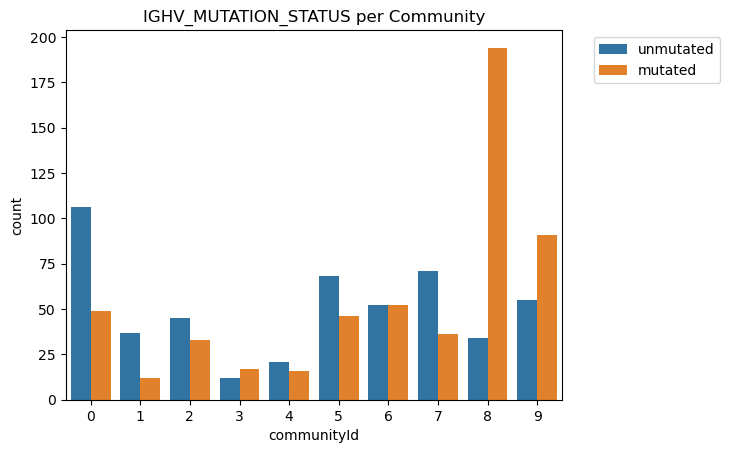


🔬 CLL_EPITYPE distribution per community:

CLL_EPITYPE     i-CLL     m-CLL     n-CLL  unclassified
communityId                                            
0            0.121795  0.198718  0.589744      0.089744
1            0.100000  0.160000  0.600000      0.140000
2            0.062500  0.312500  0.550000      0.075000
3            0.103448  0.379310  0.344828      0.172414
4            0.108108  0.189189  0.243243      0.459459
5            0.170940  0.196581  0.555556      0.076923
6            0.153846  0.288462  0.307692      0.250000
7            0.136364  0.218182  0.518182      0.127273
8            0.173160  0.601732  0.099567      0.125541
9            0.128378  0.405405  0.283784      0.182432


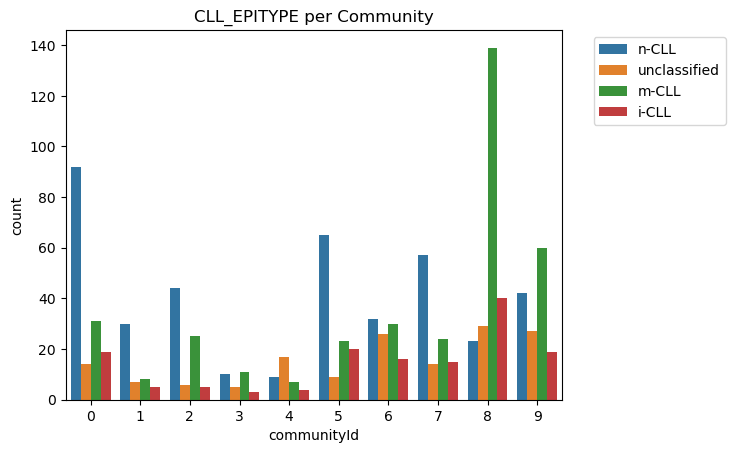


🔬 TUMOR_MOLECULAR_SUBTYPE distribution per community:

TUMOR_MOLECULAR_SUBTYPE     M-CLL     U-CLL
communityId                                
0                        0.441176  0.558824
1                        0.564103  0.435897
2                        0.500000  0.500000
3                        0.720000  0.280000
4                        0.694444  0.305556
5                        0.548077  0.451923
6                        0.597826  0.402174
7                        0.515152  0.484848
8                        0.588235  0.411765
9                        0.495935  0.504065


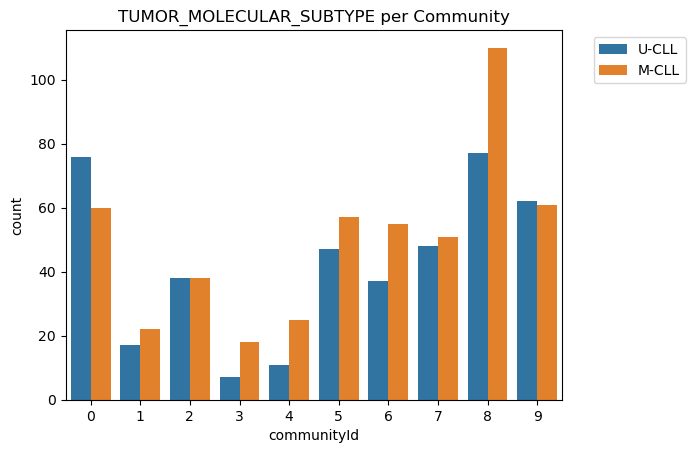


🔬 PRIOR_TREATMENT_CATEGORY distribution per community:

PRIOR_TREATMENT_CATEGORY  Ab + no Chemo  Chemo + Ab  Chemo + no Ab  LEN + Ab  \
communityId                                                                    
0                              0.000000    0.076923       0.051282  0.000000   
1                              0.020000    0.000000       0.020000  0.000000   
2                              0.000000    0.037500       0.025000  0.000000   
3                              0.000000    0.000000       0.034483  0.000000   
4                              0.000000    0.000000       0.027027  0.000000   
5                              0.000000    0.025641       0.008547  0.000000   
6                              0.000000    0.000000       0.019231  0.000000   
7                              0.009091    0.081818       0.027273  0.009091   
8                              0.000000    0.012987       0.012987  0.000000   
9                              0.006757    0.047297       0.033

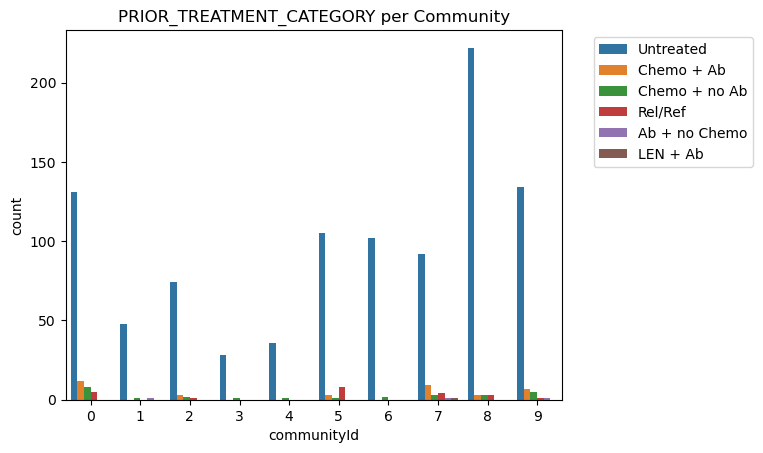


🔬 TREATMENT_AFTER_SAMPLING distribution per community:

TREATMENT_AFTER_SAMPLING  Ab + no chemo  BCL2 + Ab  BCL2 + BTK  BCL2 + chemo  \
communityId                                                                    
0                              0.096774       0.00        0.00      0.016129   
1                              0.083333       0.00        0.00      0.000000   
2                              0.000000       0.00        0.00      0.000000   
3                              0.000000       0.00        0.00      0.000000   
4                              0.055556       0.00        0.00      0.000000   
5                              0.020000       0.02        0.02      0.000000   
6                              0.022727       0.00        0.00      0.000000   
7                              0.104167       0.00        0.00      0.020833   
8                              0.060606       0.00        0.00      0.000000   
9                              0.064516       0.00        0.00 

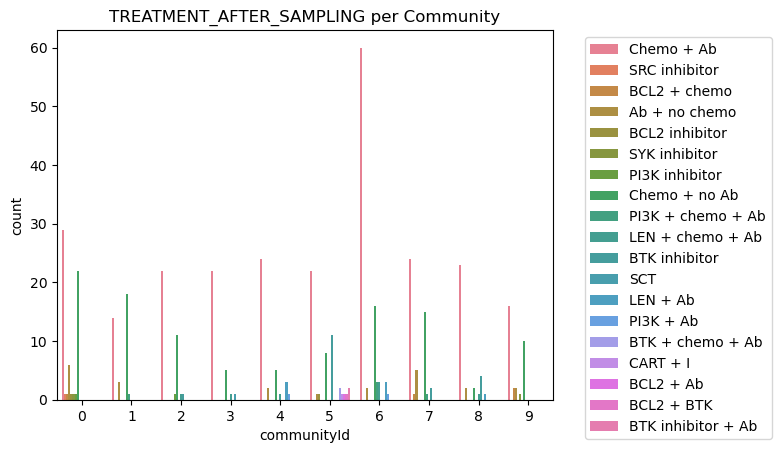

In [210]:
clinical_features = ['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE', 'PRIOR_TREATMENT_CATEGORY', 'TREATMENT_AFTER_SAMPLING']
clinical_summary(merged_df, clinical_features)

In [211]:
def get_treatment_stats_by_community(df, community_id):
    # Filter the dataframe for the given community
    community_df = df[df['communityId'] == community_id]

    # Total number of patients in the community
    total_patients = len(community_df)

    # Group by TREATMENT_AFTER_SAMPLING and count occurrences including NaN
    treatment_counts = community_df['TREATMENT_AFTER_SAMPLING'].value_counts(dropna=False)

    # Create a list of dictionaries with treatment, count, and percentage
    treatment_stats = []
    for treatment, count in treatment_counts.items():
        treatment_stats.append({
            'TREATMENT_AFTER_SAMPLING': treatment,
            '#patients': count,
            '%patients': round((count / total_patients) * 100, 2)
        })

    # Sort the list by percentage of patients in descending order
    treatment_stats_sorted = sorted(treatment_stats, key=lambda x: x['%patients'], reverse=True)

    return treatment_stats_sorted

In [212]:
treatment_data = {}
for i in range(10):
    treatment_data[i] = get_treatment_stats_by_community(merged_df, i)
treatment_data

{0: [{'TREATMENT_AFTER_SAMPLING': nan, '#patients': 94, '%patients': 60.26},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   '#patients': 29,
   '%patients': 18.59},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   '#patients': 22,
   '%patients': 14.1},
  {'TREATMENT_AFTER_SAMPLING': 'Ab + no chemo',
   '#patients': 6,
   '%patients': 3.85},
  {'TREATMENT_AFTER_SAMPLING': 'SRC inhibitor',
   '#patients': 1,
   '%patients': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 + chemo',
   '#patients': 1,
   '%patients': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'BCL2 inhibitor',
   '#patients': 1,
   '%patients': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'SYK inhibitor',
   '#patients': 1,
   '%patients': 0.64},
  {'TREATMENT_AFTER_SAMPLING': 'PI3K inhibitor',
   '#patients': 1,
   '%patients': 0.64}],
 1: [{'TREATMENT_AFTER_SAMPLING': 'Chemo + no Ab',
   '#patients': 18,
   '%patients': 36.0},
  {'TREATMENT_AFTER_SAMPLING': 'Chemo + Ab',
   '#patients': 14,
   '%patients': 28.0},
  {'TREATMENT_AFTER

In [213]:
# Function to compare two communities
def compare_two_communities_for_treatment(data, id1, id2):
    set1 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id1]}
    set2 = {gene['TREATMENT_AFTER_SAMPLING'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common treatments between community {id1} and {id2}: {common}")
    print(f"Unique to community {id1}: {unique_to_id1}")
    print(f"Unique to community {id2}: {unique_to_id2}")
    return common, unique_to_id1, unique_to_id2

In [214]:
compare_two_communities_for_treatment(treatment_data, 3, 4)

Common treatments between community 3 and 4: {'Chemo + no Ab', 'LEN + chemo + Ab', 'Chemo + Ab'}
Unique to community 3: {'SCT'}
Unique to community 4: {nan, 'LEN + Ab', 'PI3K + Ab', 'Ab + no chemo'}


({'Chemo + Ab', 'Chemo + no Ab', 'LEN + chemo + Ab'},
 {'SCT'},
 {'Ab + no chemo', 'LEN + Ab', 'PI3K + Ab', nan})

In [215]:
compare_two_communities_for_treatment(treatment_data, 0, 2)

Common treatments between community 0 and 2: {nan, 'Chemo + no Ab', 'PI3K inhibitor', 'Chemo + Ab'}
Unique to community 0: {'Ab + no chemo', 'SRC inhibitor', 'BCL2 + chemo', 'SYK inhibitor', 'BCL2 inhibitor'}
Unique to community 2: {'LEN + chemo + Ab', 'BTK inhibitor'}


({'Chemo + Ab', 'Chemo + no Ab', 'PI3K inhibitor', nan},
 {'Ab + no chemo',
  'BCL2 + chemo',
  'BCL2 inhibitor',
  'SRC inhibitor',
  'SYK inhibitor'},
 {'BTK inhibitor', 'LEN + chemo + Ab'})

In [247]:
compare_two_communities_for_treatment(treatment_data, 8, 9)

Common treatments between community 8 and 9: {nan, 'Chemo + no Ab', 'Chemo + Ab', 'Ab + no chemo'}
Unique to community 8: {'LEN + chemo + Ab', 'BTK inhibitor', 'LEN + Ab'}
Unique to community 9: {'BCL2 + chemo', 'SYK inhibitor'}


({'Ab + no chemo', 'Chemo + Ab', 'Chemo + no Ab', nan},
 {'BTK inhibitor', 'LEN + Ab', 'LEN + chemo + Ab'},
 {'BCL2 + chemo', 'SYK inhibitor'})

In [253]:
compare_two_communities_for_treatment(treatment_data, 5, 7)

Common treatments between community 5 and 7: {nan, 'Ab + no chemo', 'BTK inhibitor', 'Chemo + Ab', 'Chemo + no Ab'}
Unique to community 5: {'BCL2 + BTK', 'BTK inhibitor + Ab', 'CART + I', 'BCL2 + Ab', 'BTK + chemo + Ab', 'BCL2 inhibitor'}
Unique to community 7: {'PI3K + chemo + Ab', 'BCL2 + chemo'}


({'Ab + no chemo', 'BTK inhibitor', 'Chemo + Ab', 'Chemo + no Ab', nan},
 {'BCL2 + Ab',
  'BCL2 + BTK',
  'BCL2 inhibitor',
  'BTK + chemo + Ab',
  'BTK inhibitor + Ab',
  'CART + I'},
 {'BCL2 + chemo', 'PI3K + chemo + Ab'})

In [216]:
clinical_features = ['IGLV3_21_R110','U1_STATUS', 'EXPRESSION_CLUSTER', 'IGHV_MUTATION_STATUS']
# clinical_summary(merged_df, clinical_features)

In [217]:
clinical_features = ['COHORT','originId', 'originType']
# clinical_summary(merged_df, clinical_features)

In [218]:
# 📌 SECTION 5B: CLINICAL NUMERIC ATTRIBUTES
def clinical_numeric_summary(df, features, groupby='communityId'):
    for feat in features:
        print(f"\n🔬 {feat} distribution per community:\n")
        print(df.groupby(groupby)[feat].describe())
        
        sns.violinplot(data=df, x=groupby, y=feat)
        plt.title(f"{feat} Distribution per Community")
        plt.show()


🔬 MUTATION_COUNT distribution per community:

             count       mean         std   min   25%   50%    75%    max
communityId                                                              
0            141.0  33.553191   26.479487   7.0  22.0  30.0  40.00  293.0
1             44.0  35.522727   26.628791   7.0  19.5  31.5  41.00  142.0
2             70.0  36.985714   42.829792  10.0  19.0  26.0  37.75  320.0
3             29.0  58.862069  115.139581   7.0  19.0  28.0  40.00  556.0
4             34.0  28.705882   17.719240   4.0  18.5  24.5  34.25   78.0
5            112.0  33.821429   34.630928   8.0  20.0  25.5  33.25  310.0
6             95.0  26.852632   13.586577   4.0  19.0  24.0  31.00   78.0
7            105.0  27.447619   15.545208   5.0  18.0  25.0  33.00  113.0
8            209.0  27.449761   25.799497   4.0  17.0  24.0  31.00  331.0
9            135.0  25.585185   21.138980   6.0  16.0  22.0  28.00  197.0


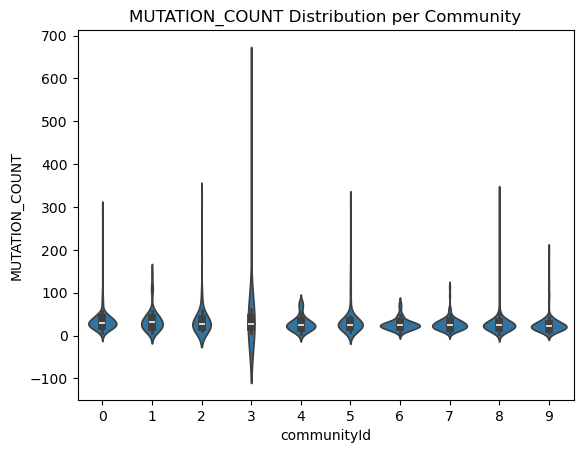

In [219]:
clinical_numeric_features = ['MUTATION_COUNT']# , 'TMB_NONSYNONYMOUS', 'IGHV_IDENTITY_PERCENTAGE']
clinical_numeric_summary(merged_df, clinical_numeric_features)

## Mutations

In [220]:
mutation_annotated = (
    mutation_df.merge(community_df, on='patientId')
    .drop_duplicates(subset=['patientId', 'communityId', 'hugoGeneSymbol'])
    .assign(has_mutation=1)
    # Now each row = patient, community, gene (unique), has_mutation=1
    # This is suitable for patient-level summaries
    # For other features, drop_duplicates on patientId, communityId, feature as needed
    # For gene-level, use hugoGeneSymbol
    # For other columns, adapt as needed
    # For patient-level summaries, groupby patientId, communityId, hugoGeneSymbol
    # For community-level, groupby communityId, hugoGeneSymbol
    # For top-N, count unique patients per gene per community
    # For plotting, use n_patients/total_patients per community
    # For other features, adapt as above
    )

In [221]:
mutation_annotated.shape

(29526, 22)

In [222]:
# 📌 SECTION 6: MUTATION ENRICHMENT ANALYSIS (Patient-level)

def mutation_enrichment(mutation_annotated, community_df, top_n_genes=20):
    # For each community and gene, count unique patients with at least one mutation
    gene_patient_counts = mutation_annotated.groupby(['communityId', 'hugoGeneSymbol'])['patientId'].nunique().unstack(fill_value=0)
    # Find top N most mutated genes overall (by unique patient count)
    top_genes = gene_patient_counts.sum(axis=0).sort_values(ascending=False).head(top_n_genes).index
    gene_counts_top = gene_patient_counts[top_genes]
    # For each community, get total unique patients
    comm_patient_counts = mutation_annotated.groupby('communityId')['patientId'].nunique()
    gene_fraction = gene_counts_top.div(comm_patient_counts, axis=0)
    sns.heatmap(gene_fraction.T, cbar_kws={'label': 'Fraction of Patients'})
    plt.title(f"Top {top_n_genes} Gene Mutation Enrichment per Community (Patient-level)")
    plt.xlabel("Community")
    plt.ylabel("Gene")
    plt.tight_layout()
    plt.show()

In [223]:
# mutation_enrichment(mutation_annotated, community_df, top_n_genes=10)

In [224]:
# 📌 SECTION 6C: PLOT CATEGORICAL FEATURES (≤10 unique values, Patient-level)
def plot_small_categoricals(df, features, groupby='communityId'):
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for feat in features:
        if df[feat].nunique() <= 10:
            print(f"\n🔹 Distribution of '{feat}' across communities (fraction of patients):")
            # For each community and value, count unique patients
            ct = df.groupby([groupby, feat])['patientId'].nunique().unstack(fill_value=0)
            ct_frac = ct.div(comm_patient_counts, axis=0)
            display(ct_frac.style.format("{:.2%}"))
            ct_frac.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,5))
            plt.title(f"{feat} Distribution by Community (Patient-level)")
            plt.ylabel("Fraction of Patients")
            plt.xlabel("Community")
            plt.legend(title=feat, bbox_to_anchor=(1.05, 1), loc='upper left')
            # annotate percentage on bars
            plt.tight_layout()
            plt.show()


In [225]:
small_categorical_features = ['mutationType', 'variantType']
# plot_small_categoricals(mutation_annotated, small_categorical_features)

In [226]:
# 📌 SECTION 6D: TOP-5 HIGH CARDINALITY CATEGORICAL FEATURES (Patient-level Percentages)
def top_values_by_community(df, col, groupby='communityId', top_n=5):
    print(f"\n🔎 Top {top_n} values of '{col}' per community (percentage of patients with at least one {col}):")
    
    rows = []
    plot_data = []
    top_mutations = {}
    # For each community, get total unique patients
    comm_patient_counts = df.groupby(groupby)['patientId'].nunique()
    for cid, sub in df.groupby(groupby):
        top_mutations[cid] = []
        total_patients = comm_patient_counts[cid]
        # For each value, count unique patients with at least one occurrence
        val_patient_counts = sub.groupby(col)['patientId'].nunique().sort_values(ascending=False).head(top_n)
        for val, n_patients in val_patient_counts.items():
            pct = 100 * n_patients / total_patients if total_patients > 0 else 0
            rows.append({'Community': cid, col: val, 'Percentage': round(pct, 2)})
            plot_data.append({'Community': cid, col: val, 'Percentage': pct})
            top_mutations[cid].append({col: val, 'Percentage': round(pct, 2)})
    
    # Table: Top N per community, percentage of patients
    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index='Community', columns=col, values='Percentage').fillna(0))

    return top_mutations
    
    # # Plot: Stacked bar, only top N per community, percentage of patients
    # plot_df = pd.DataFrame(plot_data)
    # pivot = plot_df.pivot(index='Community', columns=col, values='Percentage').fillna(0)
    # ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
    # plt.title(f"Top {top_n} '{col}' values by Community (Percent of Patients)")
    # plt.ylabel("% of Patients in Community")
    # plt.xlabel("Community")
    # plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    
    # # Annotate percentages on bars
    # for i, (idx, row) in enumerate(pivot.iterrows()):
    #     cumm = 0
    #     for j, val in enumerate(row):
    #         if val > 0:
    #             plt.text(i, cumm + val/2, f"{val:.1f}%", ha='center', va='center', fontsize=9)
    #             cumm += val
    # plt.show()

In [227]:
top_mutations = top_values_by_community(mutation_annotated, 'hugoGeneSymbol', top_n=10)
top_mutations


🔎 Top 10 values of 'hugoGeneSymbol' per community (percentage of patients with at least one hugoGeneSymbol):


hugoGeneSymbol,AHNAK,ANK3,ASXL1,ATM,ATRX,BAZ2A,BIRC3,BRAF,CHD2,COL11A1,...,SMC1A,SPEN,SYNE1,TP53,TTN,USH2A,XPO1,ZC3H18,ZFHX4,ZNF292
Community,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,9.93,0.00,0.00,0.00,7.09,0.00,0.00,...,0.00,0.00,0.00,19.15,8.51,0.00,9.93,0.00,0.00,0.00
1,0.00,0.00,9.09,25.00,0.00,0.00,0.00,6.82,0.00,0.00,...,0.00,9.09,0.00,13.64,15.91,0.00,0.00,0.00,0.00,9.09
2,0.00,0.00,0.00,14.08,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,9.86,0.00,0.00,11.27,0.00,0.00,0.00
3,17.24,10.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.34,0.00,0.00,0.00,13.79,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,8.82,8.82,0.00,0.00,0.00,8.82,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,15.18,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,17.86,8.04,0.00,8.93,0.00,0.00,0.00
6,0.00,0.00,0.00,9.47,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,6.32,0.00,6.32,6.32,0.00,0.00,6.32,0.00
7,0.00,0.00,0.00,17.14,0.00,0.00,8.57,0.00,0.00,0.00,...,0.00,5.71,0.00,10.48,0.00,0.00,6.67,5.71,0.00,0.00
8,0.00,0.00,0.00,6.22,0.00,0.00,0.00,0.00,8.13,0.00,...,0.00,0.00,0.00,0.00,6.70,0.00,0.00,0.00,0.00,0.00


{0: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(21.99)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(19.15)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(9.93)},
  {'hugoGeneSymbol': 'XPO1', 'Percentage': np.float64(9.93)},
  {'hugoGeneSymbol': 'NOTCH1', 'Percentage': np.float64(9.22)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'PCLO', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'EGR2', 'Percentage': np.float64(8.51)},
  {'hugoGeneSymbol': 'BRAF', 'Percentage': np.float64(7.09)},
  {'hugoGeneSymbol': 'POT1', 'Percentage': np.float64(7.09)}],
 1: [{'hugoGeneSymbol': 'SF3B1', 'Percentage': np.float64(34.09)},
  {'hugoGeneSymbol': 'ATM', 'Percentage': np.float64(25.0)},
  {'hugoGeneSymbol': 'TTN', 'Percentage': np.float64(15.91)},
  {'hugoGeneSymbol': 'TP53', 'Percentage': np.float64(13.64)},
  {'hugoGeneSymbol': 'ZNF292', 'Percentage': np.float64(9.09)},
  {'hugoGeneSymbol': 'SPEN', 'Percentage': np.float64(9.

In [255]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from upsetplot import UpSet


# Function to compare two communities
def compare_two_communities(data, id1, id2):
    set1 = {gene['hugoGeneSymbol'] for gene in data[id1]}
    set2 = {gene['hugoGeneSymbol'] for gene in data[id2]}
    common = set1 & set2
    unique_to_id1 = set1 - set2
    unique_to_id2 = set2 - set1
    print(f"Common mutations between community {id1} and {id2}: {common}")
    print(f"Unique to community {id1}: {unique_to_id1}")
    print(f"Unique to community {id2}: {unique_to_id2}")
    return common, unique_to_id1, unique_to_id2

# Function to compare all four communities
def compare_all_communities(data):
    sets = [set(gene['hugoGeneSymbol'] for gene in data[i]) for i in range(4)]
    common_all = set.intersection(*sets)
    unique_all = [s - set.union(*(sets[:i] + sets[i+1:])) for i, s in enumerate(sets)]
    return common_all, unique_all

In [256]:
compare_two_communities(top_mutations, 3, 4)

Common mutations between community 3 and 4: {'SF3B1'}
Unique to community 3: {'SIX4', 'CSMD1', 'DCHS2', 'SETDB1', 'AHNAK', 'TTN', 'SMC1A', 'ANK3', 'KRAS'}
Unique to community 4: {'IGLL5', 'FAT1', 'FBN2', 'BAZ2A', 'DNAH17', 'ATRX', 'COL11A1', 'PTPRB', 'CSMD3'}


({'SF3B1'},
 {'AHNAK', 'ANK3', 'CSMD1', 'DCHS2', 'KRAS', 'SETDB1', 'SIX4', 'SMC1A', 'TTN'},
 {'ATRX',
  'BAZ2A',
  'COL11A1',
  'CSMD3',
  'DNAH17',
  'FAT1',
  'FBN2',
  'IGLL5',
  'PTPRB'})

In [257]:
compare_two_communities(top_mutations, 0, 2)

Common mutations between community 0 and 2: {'NOTCH1', 'PCLO', 'ATM', 'SF3B1', 'TP53', 'XPO1'}
Unique to community 0: {'TTN', 'EGR2', 'POT1', 'BRAF'}
Unique to community 2: {'MKI67', 'COL6A3', 'LRP1B', 'CSMD3'}


({'ATM', 'NOTCH1', 'PCLO', 'SF3B1', 'TP53', 'XPO1'},
 {'BRAF', 'EGR2', 'POT1', 'TTN'},
 {'COL6A3', 'CSMD3', 'LRP1B', 'MKI67'})

In [258]:
compare_two_communities(top_mutations, 8, 9)

Common mutations between community 8 and 9: {'CSMD3', 'PCLO', 'ATM', 'MYD88', 'SF3B1', 'TTN', 'KLHL6', 'LRP1B'}
Unique to community 8: {'CHD2', 'MUC16'}
Unique to community 9: {'NOTCH1', 'TP53'}


({'ATM', 'CSMD3', 'KLHL6', 'LRP1B', 'MYD88', 'PCLO', 'SF3B1', 'TTN'},
 {'CHD2', 'MUC16'},
 {'NOTCH1', 'TP53'})

In [259]:
compare_two_communities(top_mutations, 5, 7)

Common mutations between community 5 and 7: {'POT1', 'ATM', 'SF3B1', 'TP53', 'XPO1', 'LRP1B'}
Unique to community 5: {'TTN', 'KRAS', 'HMCN1', 'MUC16'}
Unique to community 7: {'SPEN', 'NOTCH1', 'BIRC3', 'ZC3H18'}


({'ATM', 'LRP1B', 'POT1', 'SF3B1', 'TP53', 'XPO1'},
 {'HMCN1', 'KRAS', 'MUC16', 'TTN'},
 {'BIRC3', 'NOTCH1', 'SPEN', 'ZC3H18'})

{0: ['SF3B1', 'TP53', 'ATM', 'XPO1', 'NOTCH1', 'TTN', 'PCLO', 'EGR2', 'BRAF', 'POT1'], 1: ['SF3B1', 'ATM', 'TTN', 'TP53', 'ZNF292', 'SPEN', 'PTPRD', 'NOTCH1', 'ASXL1', 'BRAF'], 2: ['SF3B1', 'ATM', 'PCLO', 'XPO1', 'TP53', 'NOTCH1', 'LRP1B', 'COL6A3', 'CSMD3', 'MKI67'], 3: ['AHNAK', 'TTN', 'SF3B1', 'KRAS', 'SETDB1', 'DCHS2', 'ANK3', 'SIX4', 'SMC1A', 'CSMD1']}


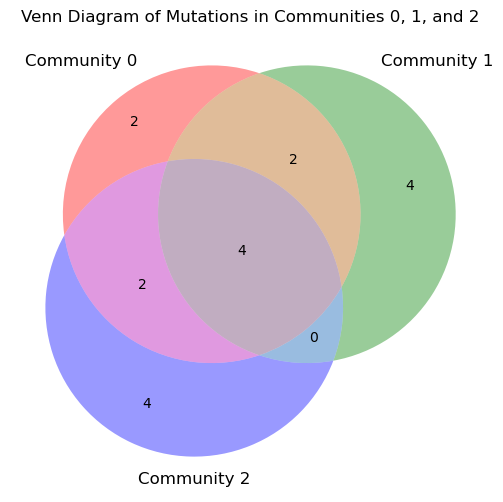

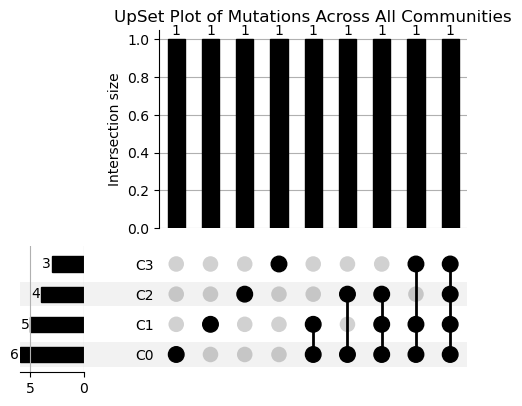

In [231]:
# Create sets for communities 0, 1, 2
mutation_data = {}
for i in range(4):
    mutation_data[i] = [i['hugoGeneSymbol'] for i in top_mutations[i]]

print(mutation_data)

set0 = set(mutation_data[0])
set1 = set(mutation_data[1])
set2 = set(mutation_data[2])

# Plot Venn diagram for communities 0, 1, 2
plt.figure(figsize=(8, 6))
venn3([set0, set1, set2], set_labels=('Community 0', 'Community 1', 'Community 2'))
plt.title("Venn Diagram of Mutations in Communities 0, 1, and 2")
plt.show()

# Prepare data for UpSet plot for all four communities
all_genes = set.union(*[set(mutation_data[i]) for i in range(4)])
data = []

for gene in all_genes:
    presence = tuple(gene in mutation_data[i] for i in range(4))
    data.append(presence)

# Create a DataFrame for UpSet plot
df = pd.DataFrame(data, columns=['C0', 'C1', 'C2', 'C3'])
df['count'] = 1
df = df.groupby(['C0', 'C1', 'C2', 'C3']).count()

# Plot UpSet plot
upset = UpSet(df, subset_size='count', show_counts=True)
upset.plot()
plt.title("UpSet Plot of Mutations Across All Communities")
plt.show()


In [232]:
columns_to_analyze = [
    'hugoGeneSymbol', 'proteinChange', 'referenceAllele', 'variantAllele'
    # Add more columns as needed
]
# for col in columns_to_analyze:
#     top_values_by_community(mutation_annotated, col)  # Patient-level analysis

In [233]:
# 📌 SECTION 6E: NUMERICAL SUMMARY (tumorAltCount, tumorRefCount)
def numeric_distribution_by_community(df, numeric_cols, groupby='communityId'):
    for col in numeric_cols:
        print(f"\n📊 Summary statistics for {col}:")
        display(df.groupby(groupby)[col].describe())

        sns.boxplot(data=df, x=groupby, y=col)
        plt.title(f"{col} Distribution by Community")
        plt.tight_layout()
        plt.show()

In [234]:
columns_to_analyze = ['tumorAltCount', 'tumorRefCount']
# numeric_distribution_by_community(mutation_annotated, columns_to_analyze)

## Survival analysis

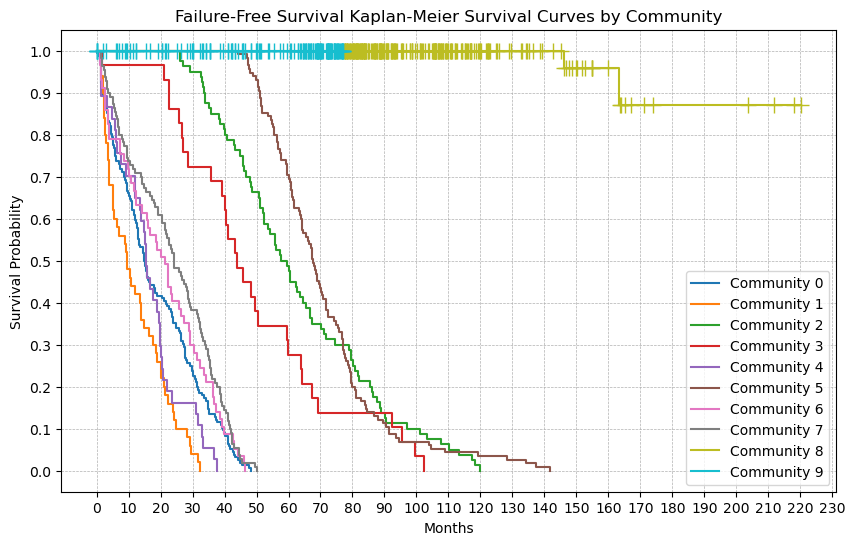

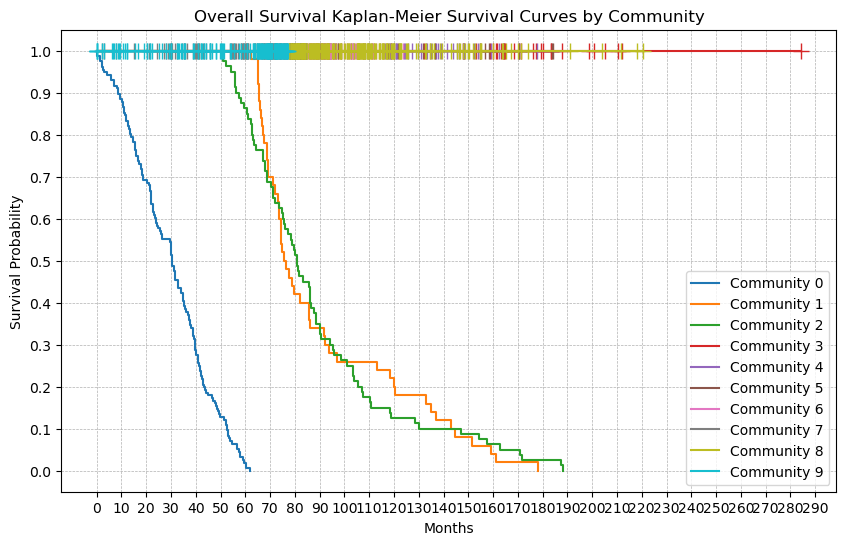

In [235]:
# 📌 SECTION 7: SURVIVAL ANALYSIS
def survival_km(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')

    plt.figure(figsize=(10,6))
    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col], label=f"Community {name}")
        kmf.plot_survival_function(ci_show=False, show_censors=True)
    plt.title(f"{label} Kaplan-Meier Survival Curves by Community")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    
    # Set ticks at every 10 units
    max_time = df[time_col].max()
    plt.xticks(np.arange(0, max_time + 10, 10))
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    if time_col == 'FFS_MONTHS':
        plt.savefig("../../figures/survival_curves.png", dpi = 300)
    else:
        plt.savefig("../../figures/os_survival_curves.png", dpi = 300)
    plt.show()

# Convert FFS_STATUS and OS_STATUS to binary event columns
merged_df['FFS_STATUS_EVENT'] = merged_df['FFS_STATUS'].str.startswith('1:').astype(int)
merged_df['OS_STATUS_EVENT'] = merged_df['OS_STATUS'].str.startswith('1:').astype(int)

survival_km(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
survival_km(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import restricted_mean_survival_time

def survival_km_with_stats(df, time_col, status_col, label='FFS'):
    kmf = KaplanMeierFitter()

    df = df.drop_duplicates(subset='patientId', keep='first')
    print(df['communityId'].value_counts())

    median_survival_times = {}
    df_median_times = {}
    df_mean_times = {}

    # Define time points for restricted mean survival time
    time_points = [float('inf'), 3, 5, 10]
    mean_survival_times_by_t = {f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)': {} for t in time_points}

    for name, grouped_df in df.groupby('communityId'):
        kmf.fit(durations=grouped_df[time_col], event_observed=grouped_df[status_col])

        # Median survival time from Kaplan-Meier curve
        median_survival_times[name] = kmf.median_survival_time_

        # Mean survival time using area under the curve at different time points
        for t in time_points:
            label_t = f'KM Mean Survival Time (t={t if t != float("inf") else "inf"} years)'
            new_t = t if t == float('inf') else t*12
            mean_survival_times_by_t[label_t][name] = restricted_mean_survival_time(kmf, t=new_t)

        # Median and mean directly from the DataFrame
        df_median_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].median()
        df_mean_times[name] = grouped_df.loc[grouped_df[status_col] == 1, time_col].mean()

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'KM Median Survival Time': median_survival_times,
        'DF Median Survival Time': df_median_times,
        'DF Mean Survival Time': df_mean_times
    })

    # Add mean survival times at different t values
    for label, values in mean_survival_times_by_t.items():
        summary_df[label] = pd.Series(values)

    return summary_df



summary_ffs = survival_km_with_stats(merged_df, 'FFS_MONTHS', 'FFS_STATUS_EVENT', label='Failure-Free Survival')
summary_os = survival_km_with_stats(merged_df, 'OS_MONTHS', 'OS_STATUS_EVENT', label='Overall Survival')

print("FFS")
display(summary_ffs)
print("OS")
display(summary_os)


communityId
8    226
0    156
9    148
5    115
7    110
2     80
6     57
1     50
4     37
3     29
Name: count, dtype: int64
communityId
8    226
0    156
9    148
5    115
7    110
2     80
6     57
1     50
4     37
3     29
Name: count, dtype: int64
FFS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,14.86,15.025,18.415577,18.415577,17.650577,18.415577,18.415577
1,9.40,9.485,12.043200,12.043200,12.043200,12.043200,12.043200
2,59.51,58.505,63.004500,63.004500,35.344375,51.715125,63.004500
3,43.76,43.760,49.223103,49.223103,32.134483,43.210345,49.223103
4,15.32,15.320,16.179459,16.179459,16.116486,16.179459,16.179459
5,67.50,67.500,70.849391,70.849391,36.000000,57.970783,70.312783
6,21.37,21.370,20.877018,20.877018,19.923333,20.877018,20.877018
7,24.16,24.230,23.710000,23.710000,22.426818,23.710000,23.710000
8,inf,154.750,154.750000,inf,36.000000,60.000000,120.000000
9,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


OS


,KM Median Survival Time,DF Median Survival Time,DF Mean Survival Time,KM Mean Survival Time (t=inf years),KM Mean Survival Time (t=3 years),KM Mean Survival Time (t=5 years),KM Mean Survival Time (t=10 years)
0,30.28,30.360,29.899295,29.899295,25.825705,29.884167,29.899295
1,75.52,76.060,91.522800,91.522800,36.000000,60.000000,86.262200
2,80.97,80.875,88.955375,88.955375,36.000000,59.342500,83.968125
3,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
4,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
5,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
6,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
7,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
8,inf,NaN,NaN,inf,36.000000,60.000000,120.000000
9,inf,NaN,NaN,inf,36.000000,60.000000,120.000000


In [237]:
# Filter rows where FFS_EVENT is 1
filtered_df = merged_df[merged_df['FFS_STATUS_EVENT'] == 1]

# Find the row with the minimum FFS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['FFS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

# Find the row with the maximum FFS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['FFS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'FFS_MONTHS']])

     communityId  FFS_MONTHS
771            0        0.07
683            1        1.12
835            2       26.01
658            3        1.55
775            4        1.02
566            5       44.28
776            6        1.02
858            7        1.35
803            8      119.18
     communityId  FFS_MONTHS
231            0       48.13
325            1       32.42
682            2      119.74
29             3      102.25
118            4       37.77
707            5      141.70
19             6       59.93
210            7       50.00
934            8      220.30
714            9       77.03


In [238]:
# Filter rows where OS_EVENT is 1
filtered_df = merged_df[merged_df['OS_STATUS_EVENT'] == 1]

# Find the row with the minimum OS_MONTHS for each communityId
result_df = filtered_df.loc[filtered_df.groupby('communityId')['OS_MONTHS'].idxmin()]

# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

# Find the row with the maximum OS_MONTHS for each communityId
result_df = merged_df.loc[merged_df.groupby('communityId')['OS_MONTHS'].idxmax()]


# Display the result
print(result_df[['communityId', 'OS_MONTHS']])

     communityId  OS_MONTHS
771            0       0.07
375            1      62.37
278            2      50.86
     communityId  OS_MONTHS
230            0      61.74
614            1     178.12
654            2     188.15
29             3     284.31
617            4     177.83
802            5     184.01
656            6     200.84
260            7      84.39
934            8     220.30
714            9      77.03


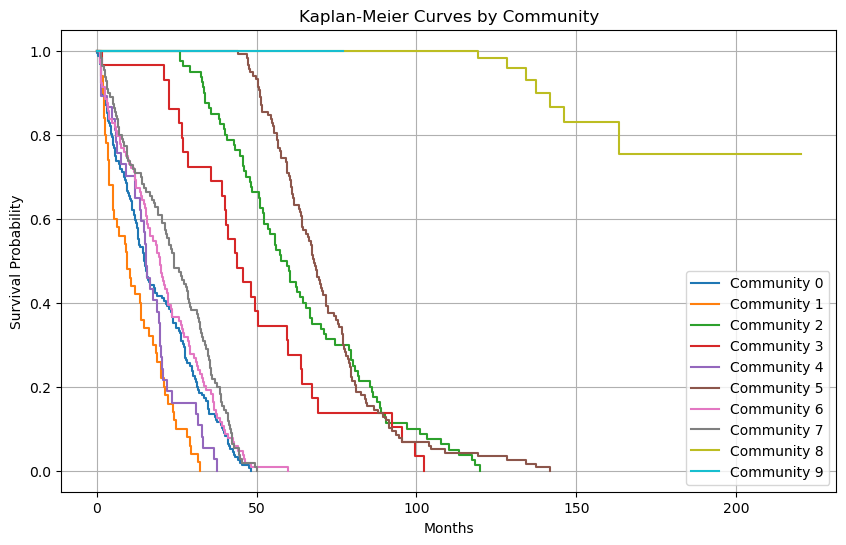

Log-Rank Test between Community 2 and 0: p = 5.620839536960058e-39
Log-Rank Test between Community 2 and 3: p = 0.024754373156605877
Log-Rank Test between Community 2 and 5: p = 0.14270452396380626
Log-Rank Test between Community 2 and 6: p = 1.439486020642594e-33
Log-Rank Test between Community 2 and 4: p = 3.881803882972484e-35
Log-Rank Test between Community 2 and 8: p = 7.609830277053095e-105
Log-Rank Test between Community 2 and 9: p = 1.4693116921120242e-21
Log-Rank Test between Community 2 and 7: p = 1.8754726353368245e-32
Log-Rank Test between Community 2 and 1: p = 4.050287786583371e-40
Log-Rank Test between Community 0 and 3: p = 3.669307402220035e-12
Log-Rank Test between Community 0 and 5: p = 3.7695959271220585e-67
Log-Rank Test between Community 0 and 6: p = 0.18790290930332115
Log-Rank Test between Community 0 and 4: p = 0.13142445319153515
Log-Rank Test between Community 0 and 8: p = 1.669005833173201e-119
Log-Rank Test between Community 0 and 9: p = 3.5349241139990995e

<lifelines.CoxPHFitter: fitted with 1062 total observations, 372 right-censored observations>
             duration col = 'FFS_MONTHS'
                event col = 'FFS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 690
   partial log-likelihood = -3496.87
         time fit was run = 2025-07-24 11:45:02 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1   0.68      1.98      0.17            0.36            1.01                1.43                2.74
communityId_2  -3.04      0.05      0.19           -3.41           -2.66                0.03                0.07
communityId_3  -2.53      0.08      0.24           -2.99           -2.06                0.05                0.13
communityId_4   0.34      1.40      0.18           -0.03            0.70                0.97                2.01
communityId_5  -3.28      0.04      0.18           -3.63           -2.92                0.03                0.05
communityId_6  -0.21      0.81      0.13           -0.46            0.04                0.63                1.04
communityId_7  -0.34      0.71      0.12           -0.58           -0.09                0.56                0.91
communityId_8  -8.15      0.00      0.49           -9.11           -7.20                0.00                0.00
communityId_9 -20.68      0.00    717.72        -1427.39         1386.02                0.00                 inf

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00   4.11 <0.005     14.65
communityId_2    0.00 -15.87 <0.005    186.01
communityId_3    0.00 -10.64 <0.005     85.46
communityId_4    0.00   1.82   0.07      3.85
communityId_5    0.00 -17.95 <0.005    236.96
communityId_6    0.00  -1.63   0.10      3.28
communityId_7    0.00  -2.72   0.01      7.25
communityId_8    0.00 -16.75 <0.005    206.80
communityId_9    0.00  -0.03   0.98      0.03
---
Concordance = 0.87
Partial AIC = 7011.75
log-likelihood ratio test = 1787.07 on 9 df
-log2(p) of ll-ratio test = inf

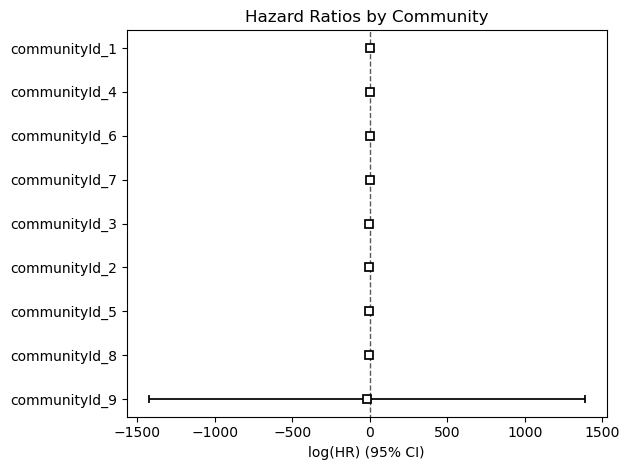

In [239]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['FFS_STATUS_EVENT'] = mod_df['FFS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['FFS_MONTHS'], group['FFS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['FFS_MONTHS'], group_b['FFS_MONTHS'],
                          event_observed_A=group_a['FFS_STATUS_EVENT'],
                          event_observed_B=group_b['FFS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['FFS_MONTHS', 'FFS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='FFS_MONTHS', event_col='FFS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

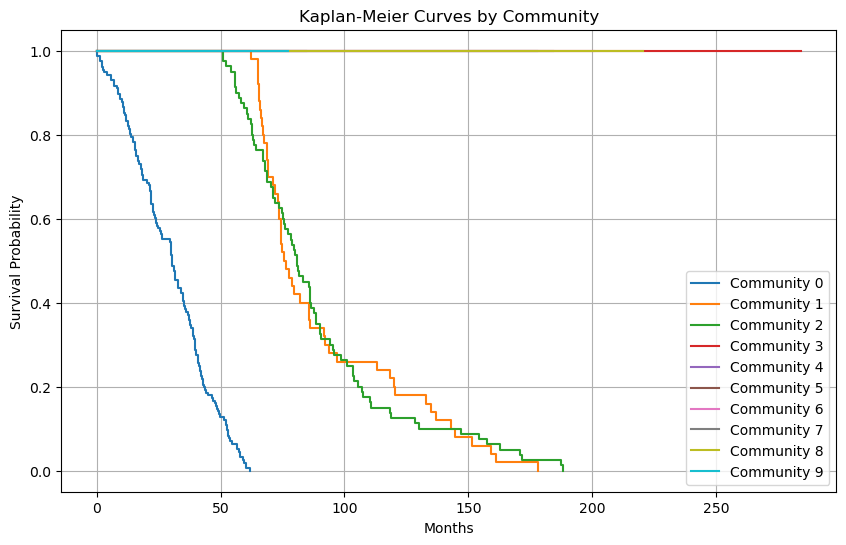

Log-Rank Test between Community 2 and 0: p = 2.510351350550825e-46
Log-Rank Test between Community 2 and 3: p = 4.415496864081551e-19
Log-Rank Test between Community 2 and 5: p = 1.3814664442772524e-28
Log-Rank Test between Community 2 and 6: p = 1.72880327190916e-39
Log-Rank Test between Community 2 and 4: p = 3.1939645674914436e-18
Log-Rank Test between Community 2 and 8: p = 1.1045728967407809e-76
Log-Rank Test between Community 2 and 9: p = 6.197558187184306e-08
Log-Rank Test between Community 2 and 7: p = 9.73791993048405e-09
Log-Rank Test between Community 2 and 1: p = 0.9977442115444316
Log-Rank Test between Community 0 and 3: p = 7.531552176471825e-23
Log-Rank Test between Community 0 and 5: p = 1.6373006163469246e-67
Log-Rank Test between Community 0 and 6: p = 2.2894856579970196e-61
Log-Rank Test between Community 0 and 4: p = 1.9385843991664533e-27
Log-Rank Test between Community 0 and 8: p = 1.8467648453084894e-119
Log-Rank Test between Community 0 and 9: p = 1.452924728645

<lifelines.CoxPHFitter: fitted with 1062 total observations, 776 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS_EVENT'
      baseline estimation = breslow
   number of observations = 1062
number of events observed = 286
   partial log-likelihood = -1171.51
         time fit was run = 2025-07-24 11:45:02 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
communityId_1  -3.99      0.02      0.34           -4.65           -3.32                0.01                0.04
communityId_2  -3.99      0.02      0.33           -4.63           -3.34                0.01                0.04
communityId_3 -26.23      0.00   6580.35       -12923.48        12871.02                0.00                 inf
communityId_4 -26.07      0.00   6944.43       -13636.91        13584.76                0.00                 inf
communityId_5 -25.75      0.00   4715.93        -9268.80         9217.30                0.00                 inf
communityId_6 -25.99      0.00   4416.17        -8681.52         8629.55                0.00                 inf
communityId_7 -25.06      0.00   6456.20       -12678.99        12628.86                0.00                 inf
communityId_8 -25.92      0.00   3076.15        -6055.06         6003.21                0.00                 inf
communityId_9 -24.87      0.00   6281.30       -12336.00        12286.26                0.00                 inf

               cmp to      z      p  -log2(p)
covariate                                    
communityId_1    0.00 -11.77 <0.005    103.86
communityId_2    0.00 -12.14 <0.005    110.31
communityId_3    0.00  -0.00   1.00      0.00
communityId_4    0.00  -0.00   1.00      0.00
communityId_5    0.00  -0.01   1.00      0.01
communityId_6    0.00  -0.01   1.00      0.01
communityId_7    0.00  -0.00   1.00      0.00
communityId_8    0.00  -0.01   0.99      0.01
communityId_9    0.00  -0.00   1.00      0.00
---
Concordance = 0.95
Partial AIC = 2361.01
log-likelihood ratio test = 1341.98 on 9 df
-log2(p) of ll-ratio test = 938.70

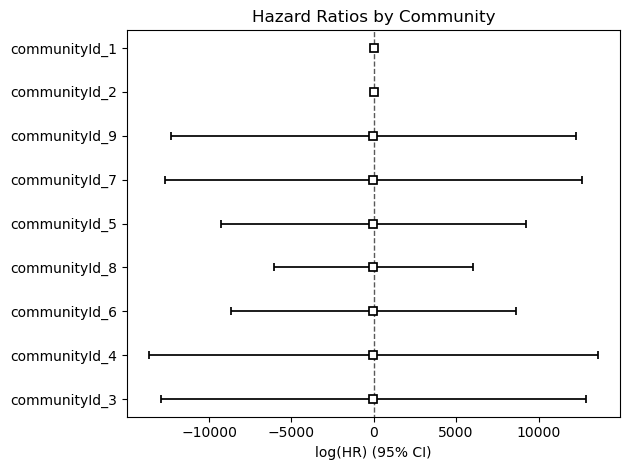

In [240]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
mod_df = merged_df.copy(deep=True)
mod_df['OS_STATUS_EVENT'] = mod_df['OS_STATUS'].str.startswith('1:').astype(int)
mod_df = mod_df.dropna(subset=['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId'])

# Kaplan-Meier Plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for name, group in mod_df.groupby('communityId'):
    kmf.fit(group['OS_MONTHS'], group['OS_STATUS_EVENT'], label=f"Community {name}")
    kmf.plot_survival_function(ci_show=False)
plt.title("Kaplan-Meier Curves by Community")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Log-Rank Test (pairwise)
from itertools import combinations
for a, b in combinations(mod_df['communityId'].unique(), 2):
    group_a = mod_df[mod_df['communityId'] == a]
    group_b = mod_df[mod_df['communityId'] == b]
    result = logrank_test(group_a['OS_MONTHS'], group_b['OS_MONTHS'],
                          event_observed_A=group_a['OS_STATUS_EVENT'],
                          event_observed_B=group_b['OS_STATUS_EVENT'])
    print(f"Log-Rank Test between Community {a} and {b}: p = {result.p_value}")

# Cox Proportional Hazards Model
mod_df['communityId'] = mod_df['communityId'].astype('category')
cox_df = pd.get_dummies(mod_df[['OS_MONTHS', 'OS_STATUS_EVENT', 'communityId']], drop_first=True)
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='OS_MONTHS', event_col='OS_STATUS_EVENT')
cph.print_summary()
cph.plot()
plt.title("Hazard Ratios by Community")
plt.tight_layout()
plt.show()

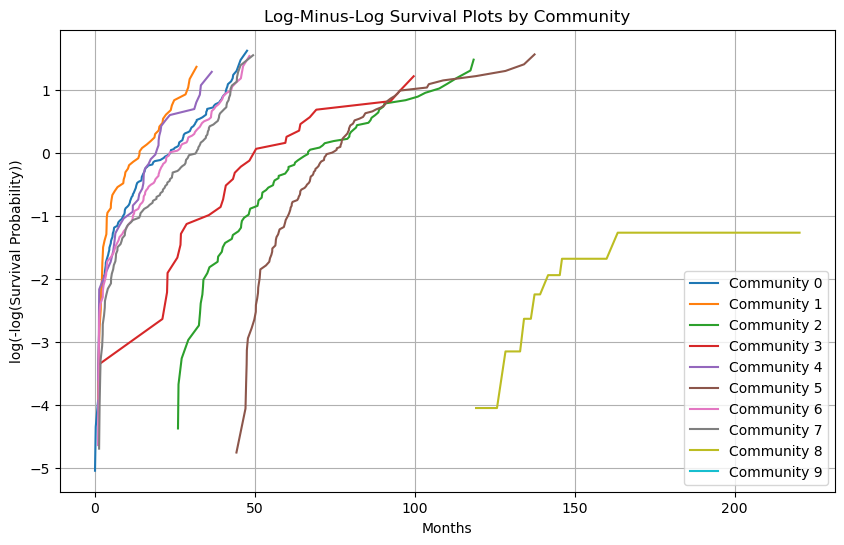

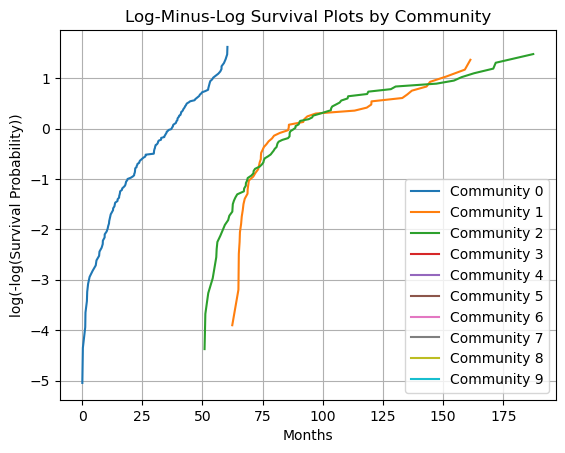

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Log-minus-log plots
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for label in ['FFS', 'OS']:
    for name, group in mod_df.groupby('communityId'):
        kmf.fit(group[f'{label}_MONTHS'], group[f'{label}_STATUS_EVENT'], label=f"Community {name}")
        survival_prob = kmf.survival_function_[f"Community {name}"]
        log_minus_log = np.log(-np.log(survival_prob))
        plt.plot(survival_prob.index, log_minus_log, label=f"Community {name}")

    plt.title("Log-Minus-Log Survival Plots by Community")
    plt.xlabel("Months")
    plt.ylabel("log(-log(Survival Probability))")
    plt.legend()
    plt.grid(True)
    plt.show()


## Extra

In [242]:
# 📌 SECTION 8: STATISTICAL TESTS
def run_statistical_tests(df, groupby='communityId'):
    print("\n📊 Kruskal-Wallis Test for AGE_SAMPLING:")
    groups = [group['AGE_SAMPLING'].dropna() for _, group in df.groupby(groupby)]
    print(kruskal(*groups))

    for feat in ['SEX', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE']:
        print(f"\n📊 Chi-square Test for {feat}:")
        contingency = pd.crosstab(df[groupby], df[feat])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}")

run_statistical_tests(merged_df)


📊 Kruskal-Wallis Test for AGE_SAMPLING:
KruskalResult(statistic=np.float64(46.061285687073074), pvalue=np.float64(5.86638232373302e-07))

📊 Chi-square Test for SEX:
Chi2 = 27.88, p-value = 0.0010

📊 Chi-square Test for CLL_EPITYPE:
Chi2 = 231.84, p-value = 0.0000

📊 Chi-square Test for TUMOR_MOLECULAR_SUBTYPE:
Chi2 = 16.87, p-value = 0.0508


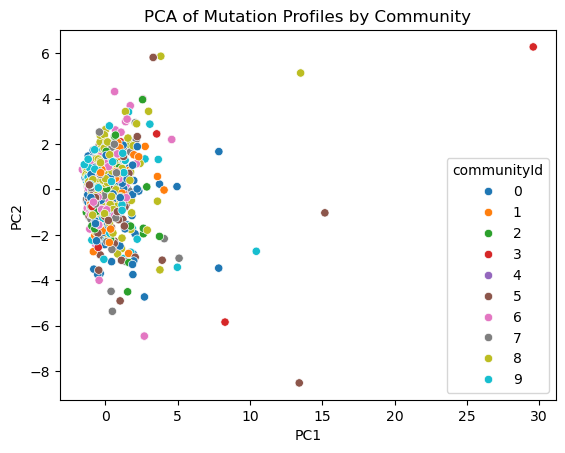

In [243]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns

# Subset features (e.g., top 50 genes across all patients)
# pivot: patients x genes (1 if mutated, 0 otherwise)
mut = mutation_df.copy()
mut['mut_flag'] = 1
mut_matrix = mut.pivot_table(index='patientId', columns='hugoGeneSymbol', values='mut_flag', fill_value=0)

# Filter top 100 mutated genes
top_genes = mut['hugoGeneSymbol'].value_counts().head(100).index
mut_matrix = mut_matrix[top_genes.intersection(mut_matrix.columns)]

# Merge with community labels
feat_df = pd.merge(mut_matrix.reset_index(), community_df, on='patientId')

# Standardize and reduce
X = StandardScaler().fit_transform(feat_df[top_genes])
pca = PCA(n_components=2).fit_transform(X)
feat_df['PC1'], feat_df['PC2'] = pca[:,0], pca[:,1]

sns.scatterplot(data=feat_df, x='PC1', y='PC2', hue='communityId', palette='tab10')
plt.title("PCA of Mutation Profiles by Community")
plt.show()


In [244]:
# pip install gseapy
import gseapy as gp

gene_list = list(mut_matrix.columns[mut_matrix.sum() > 10])  # example threshold
enr = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2021_Human', outdir=None)
enr.results[['Term', 'Adjusted P-value', 'Overlap']]


,Term,Adjusted P-value,Overlap
0,Thyroid cancer,0.000090,5/37
1,Hepatitis B,0.000090,8/162
2,Bladder cancer,0.000090,5/41
3,Chronic myeloid leukemia,0.000090,6/76
4,Endometrial cancer,0.000337,5/58
...,...,...,...
158,Neutrophil extracellular trap formation,0.629424,1/189
159,Pathogenic Escherichia coli infection,0.641095,1/197
160,Diabetic cardiomyopathy,0.648343,1/203
161,Coronavirus disease,0.693794,1/232


## Visualisation

In [245]:
# get nodes table with community assignments and edges table with source, target, weight
from collections import Counter, defaultdict

# Step 1: Build mapping from patientId to all their communities
patient_to_comms = defaultdict(set)
for _, row in community_df.iterrows():
    patient_to_comms[row['patientId']].add(row['communityId'])

# Step 2: Assign new community IDs for overlaps
overlap_map = {}  # tuple of communities -> new communityId
next_overlap_id = max(community_df['communityId'].max() + 1, 4)  # start from 4 or next available

node_rows = []
for pid, comms in patient_to_comms.items():
    comms_tuple = tuple(sorted(comms))
    if len(comms_tuple) == 1:
        # Single community, keep as is
        node_rows.append({'nodeId': pid, 'communityId': comms_tuple[0]})
    else:
        # Overlapping, assign new communityId
        if comms_tuple not in overlap_map:
            overlap_map[comms_tuple] = next_overlap_id
            next_overlap_id += 1
        node_rows.append({'nodeId': pid, 'communityId': overlap_map[comms_tuple]})

nodes_df = pd.DataFrame(node_rows)

# Map patientId to nodeId using mapping_df as before
G = nx.read_gml(os.path.join(base_path, "graph.gml"), label='id')
mapping_df = pd.read_csv(os.path.join(base_path, "patient_id_mapping.csv"))
mapping_df['nodeId'] = mapping_df['nodeId'].astype(int)
mapping_dict = mapping_df.set_index('patientId')['nodeId'].to_dict()
nodes_df['Id'] = nodes_df['nodeId'].map(mapping_dict)

# Remove any rows with missing nodeId (if mapping is incomplete)
nodes_df = nodes_df.dropna(subset=['Id'])
nodes_df.drop(columns='nodeId', inplace=True)  # keep only Id and communityId

# Edges as before
edges_df = pd.DataFrame(G.edges(data=True), columns=['source', 'target', 'data'])
edges_df['weight'] = edges_df['data'].apply(lambda x: x.get('weight', 1))  # default weight to 1 if not present
edges_df.drop(columns='data', inplace=True)

# Save nodes and edges to CSV for visualization
nodes_df.to_csv(os.path.join(base_path, algo, 'nodes.csv'), index=False)
edges_df.to_csv(os.path.join(base_path, algo, 'edges.csv'), index=False)

# Print mapping of overlaps for reference
print("Overlap group mapping (tuple of original communities -> new communityId):")
for k, v in overlap_map.items():
    print(f"{k} -> {v}")

Overlap group mapping (tuple of original communities -> new communityId):
(3, 6) -> 10
(3, 5) -> 11
(4, 6) -> 12
(5, 8) -> 13


In [246]:
resolved_df = nodes_df.copy(deep=True)
# if 4, but replace with 1, if 5 replace with 2
resolved_df['communityId'] = resolved_df['communityId'].replace({4: 1, 5: 2,})

# based on this new resolved_df and G, compute newman girvan modularity
from cdlib.evaluation import newman_girvan_modularity
from cdlib import NodeClustering
# Use the resolved_df to get communities
resolved_communities = resolved_df['communityId'].unique()

communities = {cid: set(resolved_df[resolved_df['communityId'] == cid]['Id']) for cid in resolved_communities}
communities_list = list(communities.values())
communities_node_clustering = NodeClustering(communities_list, G, method_name="SLPA_Leiden_Resolved")
modularity = newman_girvan_modularity(G, communities_node_clustering).score
print(f"Newman-Girvan Modularity: {modularity:.4f}")

Newman-Girvan Modularity: 0.3844
